# 605.649 — Introduction to Machine Learning
##  Programming Project 4  
## Lgistic Regression & Adaline
  
[Project4]
1. Breast Cancer
https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Original%29
This breast cancer databases was obtained from the University of Wisconsin Hospitals, Madison from
Dr. William H. Wolberg.
2. Glass
https://archive.ics.uci.edu/ml/datasets/Glass+Identification
The study of classification of types of glass was motivated by criminological investigation.
3. Iris
https://archive.ics.uci.edu/ml/datasets/Iris
The data set contains 3 classes of 50 instances each, where each class refers to a type of iris plant.
4. Soybean (small)
https://archive.ics.uci.edu/ml/datasets/Soybean+%28Small%29
A small subset of the original soybean database.
5. Vote
https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records
This data set includes votes for each of the U.S. House of Representatives Congressmen on the 16 key votes identified by the Congressional Quarterly Almanac. Remember that “?” represents “abstain.” When using these data sets, be careful of some issues.
1. Not all of these data sets correspond to 2-class classification problems. 
A method for handling multiclassclassification was described for Logistic Regression. For Adaline, you will need to treat the outputs independently. Note that if you wish to apply a one-vs-one or one-vs-all strategy for the Adaline neuralnetwork, that is acceptable. Just be sure to explain your strategy in your report.
2. Some of the data sets have missing attribute values, which is usually indicated by “?”. 
When thisoccurs in low numbers, you may simply edit the corresponding data items out of the data sets. Formore occurrences, you should do some kind of “data imputation” where, basically, you generate avalue of some kind. A naïve approach is to impute the missing value with a random number or the attribute’s mean (or median). A better approach is to sample according to the conditional probability of the values occurring, given the underlying class for that example. The choice of strategy is yours, but be sure to document your choice.
3. The attributes should not require any special handling with either model.
It is highly recommended that you normalize the numerical attributes first to be in the range -1 to +1 or by using z-score normalization (i.e., z = (x 􀀀 )=) and apply the inputs directly. 

For this project, the following steps are required:
-  Download the five (5) data sets from the UCI Machine Learning repository. You can find this repositoryat http://archive.ics.uci.edu/ml/. The data sets are also available in Blackboard. All of the specific URLs are also provided above.
-  Pre-process each data set as necessary to handle missing data and proper normalization.
-  Implement Adaline and Logistic Regression.
-  Run your algorithms on each of the data sets. These runs should be done with 5-fold cross-validation so you can compare your results statistically. You can use classification error, cross entropy loss, or mean squared error (as appropriate) for your loss function. Note that there are a number of hyper-parameters that also need to be tuned.
- Run your algorithms on each of the data sets. These runs should output the learned models in a way that can be interpreted by a human, and they should output the classifications on all of the test examples. If you are doing cross-validation, just output classifications for one fold each.
- Write a very brief paper that incorporates the following elements, summarizing the results of your experiments. Your paper is required to be at least 5 pages and no more than 10 pages using the JMLR format You can find templates for this format at http://www.jmlr.org/format/format.html. The format is also available within Overleaf.
1. Title and author name
2. Problem statement, including hypothesis, projecting how you expect each algorithm to perform
3. Brief description of your experimental approach, including any assumptions made with your algorithms
4. Presentation of the results of your experiments
5. A discussion of the behavior of your algorithms, combined with any conclusions you can draw
6. Conclusion
7. References (Only required if you use a resource other than the course content.)
-  Submit your fully documented code, the video demonstrating the running of your programs, and your paper.
-  For the video, the following constitute minimal requirements that must be satisfied:
    - The video is to be no longer than 5 minutes long.
    - The video should be provided in mp4 format. Alternatively, it can be uploaded to a streaming service such as YouTube with a link provided.
    - Fast forwarding is permitted through long computational cycles. Fast forwarding is not permitted whenever there is a voice-over or when results are being presented.
    - Be sure to provide verbal commentary or explanation on all of the elements you are demonstrating.
    - Provide sample outputs from one test set showing classification performance on Adaline and Logistic Regression.
    - Show a sample trained Adaline model and Logistic Regression model.
    - Demonstrate the weight updates for Adaline and Logistic Regression. For Logistic Regression, show the multi-class case.
    - Demonstrate the gradient calculation for Adaline and Logistic Regression. For Logistic Regression, show the multi-class case.
    - Show the average performance over the five folds for Adaline and Logistic Regression.

In [1]:
# Importing Libraries
%matplotlib inline
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import copy
from numpy import array, newaxis, expand_dims

# Loading Data and Preprocessing

### Helper Functions

In [2]:
def str_to_int(df, col_indx):
    """
    Function to convert string value to unique integers **in place** and return dictionary 
    Input: df :pd.DataFrame
           col_index: column index
    output: dictionary: dict to map str : int
    """
    col = df[col_indx]
    row = len(col)
    keys = pd.unique(df[col_indx])
    dictionary = dict(zip(keys, np.linspace(0,len(keys)-1,len(keys),dtype=int)))
    for j in range(row):
        df.iloc[j, col_indx] = dictionary[df[col_indx][j]]
    return dictionary

In [3]:
def normalize(col, e = 1e-9):
        """
        convert array into a z-score 
        input: column vector
        output: z-scored column vector
        """
        mu = np.mean(col)
        std = np.std(col)
        return np.array([(x-mu+e)/(std+e) for x in col])

In [4]:
def normalize_data(df, e = 1e-9):
    """
    turns a dataframe into z-score values
    input : pd.DataFrame
    """ 
    n_row, n_col = df.shape
    df_norm = df.copy()
    
    for idx in range(n_col):
        df_norm.iloc[:, idx] = normalize(df.iloc[:,idx])
        
    return df_norm

In [5]:
# one hot encoding 
def one_hot(col):
    keys = np.unique(col)
    dictionary = dict(zip(keys, np.linspace(0,len(keys)-1,len(keys),dtype=int)))
    mat = []
    for val in col:
        arr = [0]*len(keys)
        arr[dictionary[val]] = 1
        mat.append(arr)
    return mat

## Data 

In [6]:
# Breast Cancer (classification)
# the last column is the target
file_loc = './Data_Set/breast-cancer-wisconsin.data'
bc = pd.read_csv(file_loc, header = None)
bc = bc.iloc[:, 1:] # dropping 1st column since they are unique identifiers.
bc.columns = [i for i in range(len(bc.columns))] #fixing the columns index num
#imputing missing values
NAs = []
for i in range(10):
    for j in range(698):
        if bc[i][j]== '?':
            NAs.append([i,j])
bc_vals = bc[5][bc[5]!='?'].astype('int')
samples = np.random.choice(bc_vals, 16).copy()  ## imputing missing value with sample taken from the same feature col.
for k, i in enumerate(NAs):
    bc.iloc[i[1],i[0]] = samples[k]
for col in range(bc.shape[1]):        # converting all num to np.int64
    bc[col] = bc[col].astype('int64')
bc_X = bc.iloc[:, :-1]
bc_X_norm = normalize_data(bc_X)
bc_X = np.array(bc_X_norm).T
bc_y = np.array([0 if x == 2 else 1 for x in bc.iloc[:,-1]])
bc_X.shape

(9, 699)

In [231]:
# Glass
file_loc = './Data_Set/glass.data'
glass = pd.read_csv(file_loc, header = None)
glass = glass.iloc[:, 1:] # dropping 1st column since they are unique identifiers.
glass_label = np.array(glass.iloc[:, -1])
glass_y = np.array(glass.iloc[:, -1])
glass_X = glass.iloc[:, :-1]
glass_X_norm = normalize_data(glass_X).T # converting to z-score
glass_X = np.array(glass_X_norm)
glass_y = np.array(glass_y)-1
glass_y = np.array(one_hot(glass_y)).T
glass_X

array([[ 0.87286769, -0.24933306, -0.72131749, ...,  0.75404643,
        -0.612398  , -0.41436258],
       [ 0.28495326,  0.59181718,  0.14993314, ...,  1.16872135,
         1.19327046,  1.00915211],
       [ 1.25463857,  0.63616803,  0.60142249, ..., -1.86551055,
        -1.86551055, -1.86551055],
       ...,
       [-0.14576634, -0.79373376, -0.82894938, ..., -0.36410319,
        -0.33593069, -0.23732695],
       [-0.35287683, -0.35287683, -0.35287683, ...,  2.95320036,
         2.81208731,  3.01367738],
       [-0.58645089, -0.58645089, -0.58645089, ..., -0.58645089,
        -0.58645089, -0.58645089]])

In [8]:
# iris
file_loc = './Data_Set/iris.data'
iris = pd.read_csv(file_loc, header = None)
str_to_int(iris, 4) # converting string to int
iris_label = np.array(iris.iloc[:, -1])
iris_y = np.array(iris.iloc[:, -1])
iris_X = iris.iloc[:, :-1]
iris_X_norm = normalize_data(iris_X) # converting to z-score
iris_X = np.array(iris_X_norm).T
iris_y = np.array(one_hot(iris_y)).T
iris_X.shape

(4, 150)

In [9]:
# soybean
file_loc = './Data_Set/soybean-small.data'
soybean = pd.read_csv(file_loc, header = None)
str_to_int(soybean, 35)
soybean_label = soybean.iloc[:, -1]
soybean_y = soybean.iloc[:, -1]
soybean_X = soybean.iloc[:, :-1]
soybean_X_norm = normalize_data(soybean_X) # converting to z-score
soybean_X = np.array(soybean_X_norm).T
soybean_y = np.array(soybean_y)
soybean_y = np.array(one_hot(soybean_y)).T
soybean_X.shape

(35, 47)

In [10]:
# vote 
file_loc = './Data_Set/house-votes-84.data'
vote = np.loadtxt(file_loc,delimiter=',', dtype=str)
# replaceing y =1, n= -1, ? = 0
d_vote = {'republican':1, 'democrat':0, 'n':-1, 'y':1, '?':0}
vote_X = vote[:,1:] # features
n_row, n_col= vote_X.shape
vote_X_num = vote_X.copy()
vote_X_norm = vote_X.copy()
for i in range(n_row):
    for j in range(n_col):
        vote_X_num[i, j] = d_vote[vote_X[i,j]]
vote_X_num = vote_X_num.astype(float)
for i in range(n_col):
    vote_X_norm[:, i] = normalize(vote_X_num[:,i])
vote_X= vote_X_norm.astype(float).T
# extracting target and converting it to integers as 'republican':1, 'democrat':0
vote_y = np.array([d_vote[party] for party in vote[:,0]]).T # target 
vote_X.shape

(16, 435)

## Cross Validation 

In [11]:
# cross_validation (stratefied) 5 fold:
def stratefied_cross_validation(data_y, k_fold = 5):
    """
    Function to split data for stratefied k-fold cv testing where each group have same class representation, plus 10% validation set
    Input: data_X, data_y -- original data, target feature id
    Output: k_fold_idx, tuning_set -- 'indeces' of stratefied k-fold cv sets, and tuning set 
    """
    N = data_y.shape[0]
    index = [i for i in range(N)]
    np.random.shuffle(index)
    tuning_set = index[:int(N/10)]
    remain= index[int(N/10):]
    # among the remain, group the data into each classifications
    k_splits = [[] for _ in range(k_fold)]
    classes = np.unique(data_y)
    for c in classes:
        group = [idx for idx in remain if data_y[idx]==c]
        np.random.shuffle(group)
        group_k_splits = np.array_split(group, k_fold)
        np.random.shuffle(group_k_splits)
        for k in range(k_fold):
            holdout = group_k_splits[k]
            np.random.shuffle(holdout)
            k_splits[k].extend(holdout)
            
    k_fold_idx = []
    for k in range(k_fold):
        test_set = k_splits[k]
        training_idx = [i for i in range(k_fold) if i !=k]
        train_set = []
        for i in training_idx:
            train_set.extend(k_splits[i])
        k_fold_idx.append((train_set, test_set))   
        
    return k_fold_idx, tuning_set

## Helper functions

In [12]:
def accuracy(test_y, y_hats):
    """
    Input: data_y, true value vector, y_hat, prediction vector
    Output: accuracy as number of correct prediction/ total population
    """
    correct = 0
    N = len(test_y)
    for i in range(len(test_y)):
        correct += test_y[i] == y_hats[i]
    return correct/N

In [13]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Input: z, np.array
    Output: s, sigmoid(z)
    """ 
    return 1/(1+np.exp(-z)) 

In [14]:
def initialize(m, c):
    """
    Input: m -- size of the w vector
           c -- num of class
    Output:w -- initialized vector of shape (n, 1)
           b -- initialized scalar (0)
    """
    w = np.random.uniform(-0.01, 0.01, (m*c))
    W = np.reshape(w, (c, m))#[:,:,newaxis]
    b = np.zeros((c,1))
    return W, b

In [15]:
m, n = bc_X.shape
c = len(np.unique(bc_y))
W, B = initialize(m, c)

In [16]:
X = bc_X
i = 0
Y = bc_y
sigmoid(np.dot(W[0].T, X)+B[0])
A = sigmoid(np.dot(W[0].T,X)+B[0])                     
# compute activation
cross_entropy =  -np.mean(Y*np.log(A)+(1-Y)*np.log(1-A))
cross_entropy

0.6976859980744126

In [258]:
def softmax(p):
    """
    Input: p -- vector containg (x.TX+b) terms for each data points, size (num_class, num samples)
    Output: p_softmax -- data of size (num_class, num samples)
    """
    nom = np.exp(p)
    denom = nom.sum(axis = 1)[:, None]
    return nom/denom

In [169]:
X = soybean_X
Y = soybean_y
label = soybean_label
m, n = X.shape
c = len(np.unique(soybean_label))
W, B = initialize(m, c)
p = np.dot(W, X)+B
A =softmax(p)

In [227]:
cross_entropy = - np.mean(np.dot(Y.T, np.log(A))+np.dot((1-Y).T,np.log(1-A)))
dw = (1/n)*np.dot((A-Y), X.T)
p

<ipython-input-227-d33f2a990913>:3: RuntimeWarning: overflow encountered in exp
  np.exp(1e10)


inf

In [171]:
np.mean((A-Y), axis = 1).reshape(B.shape)

array([[-0.19148936],
       [-0.19148936],
       [-0.19148936],
       [-0.34042553]])

In [223]:
X = glass_X
Y = glass_y
label = glass_label
m, n = X.shape
c = len(np.unique(label))
W, B = initialize(m, c)
p = np.dot(W, X)+B
e = 1e-9
A =softmax(p)
cross_entropy = -np.mean(np.dot(Y.T, np.log(A+e))+np.dot((1-Y).T,np.log(1-A+e)))
dw = (1/n)*np.dot((A-Y), X.T)#.reshape(w.shape)
dw.shape

(6, 9)

In [267]:
def train(w, b, X, Y, multiclass = False):
    """
    Implement the cross_entropy function and its gradient

    Inputs:
    w -- weights, a numpy array of size (feature, num class)
    b -- bias, a scalar for binary, a vecor of l
    X -- data of size (feature, number of examples)
    Y -- true "label" vector of size (1, number of examples)

    Outputs:
    cross_entropy -- negative log-likelihood cross_entropy for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    """
    e = 1e-9
    
    m, n = X.shape  # number of samples in train set
    
    if multiclass == False:
        # Find a & cross_entropy
        A = sigmoid(np.dot(w.T,X)+b)   # activation
        cross_entropy = (1/n)*np.sum(Y*np.log(A+e)+(1-Y)*np.log(1-A+e))  # cross_entropy
        # update for GRADIENT DESCENT
        dw = (1/n)*np.dot(X,(A-Y).T).reshape(w.shape)
        db = (1/n)*np.sum(A-Y).reshape(b.shape)
        
    else:
        A = softmax(np.dot(w, X)+b)
        cross_entropy = -np.mean(np.dot(Y.T, np.log(A+e))+np.dot((1-Y).T,np.log(1-A+e)))  # cross_entropy
        # update for GRADIENT DESCENT
        dw = (1/n)*np.dot((A-Y), X.T).reshape(w.shape)
        db = (1/n)*np.sum((A-Y), axis= 1).reshape(b.shape)    
        
    assert(dw.shape == w.shape)
    assert(db.shape == b.shape)
    cross_entropy = np.squeeze(cross_entropy)
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cross_entropy

In [245]:
m, n = bc_X.shape
c = len(np.unique(bc_y))
W, B = initialize(m, c)
X = bc_X
Y = bc_y
train(W[0], B[0], X, Y)

({'dw': array([-0.33798794, -0.38556399, -0.38610233, -0.3282293 , -0.3209211 ,
         -0.38029845, -0.35609001, -0.33469545, -0.19742554]),
  'db': array([0.15522145])},
 0.6873719954778436)

In [246]:
def gradient_descent(w, b, X, Y, multiclass = False, num_iterations = 10000, learning_rate = 0.0001, tol = 1e-5):
    """
    This function optimizes w and b by running a gradient descent algorithm
    Inputs:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (features, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    
    Outputs:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cross_entropy function
    cross_entropys -- list of all the cross_entropys computed during the optimization, this will be used to plot the learning curve.
    """
    
    cross_entropys = []
    
    for i in range(num_iterations):
        if multiclass == False: 
            # cross_entropy and gradient calculation
            grads, cross_entropy = train(w, b, X, Y)
        else:
            # cross_entropy and gradient calculation
            grads, cross_entropy = train(w, b, X, Y, multiclass = True)
            
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        if abs(db).any() <tol:
            break
            
        # update rule
        w = w-learning_rate*dw
        b = b-learning_rate*db
        
        # Record the cross_entropys
        if i%100 == 0:
            cross_entropys.append(cross_entropy)
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, cross_entropys

In [247]:
def predict_binary(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (number of feature, 1)
    b -- bias, a scalar
    X -- data of size (number of feature, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''   
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    A = sigmoid(np.dot(w.T,X)+b) 
    p = np.zeros_like(A)
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        p[0,i] = A[0,i]>0.5

    Y_prediction = p.astype(int)
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [248]:
X = bc_X
m, n = bc_X.shape
c = len(np.unique(bc_y))
W, B = initialize(m, c)
y_hats =[]
Y = bc_y
w = W[0]
b = B[0]
params, grads, cross_entropys = gradient_descent(w, b, X, Y, num_iterations= 10000, learning_rate = 0.005, tol = 1e-4)
w1 = params['w']
b1 = params['b']
y_i = sigmoid(np.dot(w1.T, X)+b1)
y_pred = predict_binary(w1, b1, X)
accuracy(y_pred.flatten(),bc_y.flatten())

0.9685264663805436

In [249]:
def predict_multiclass(W,B,X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (features, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    m, n = X.shape
    
    p = np.dot(W, X)+B    
    p_softmax = softmax(p)
    Y_prediction = p_softmax.argmax(axis = 0).reshape(1, n)
    
    assert(Y_prediction.shape == (1, n))
    
    return Y_prediction, p_softmax

In [250]:
X = soybean_X
m, n = soybean_X.shape
c = len(np.unique(soybean_label))
W, B = initialize(m, c)
Y = soybean_y
w = W
b = B
params, grads, cross_entropys = gradient_descent(w, b, X, Y, multiclass=True,  num_iterations= 10000, learning_rate = 0.005, tol = 1e-4)
w1 = params['w']
b1 = params['b']
Y_prediction, p_softmax = predict_multiclass(w1,b1,X)
accuracy(Y_prediction.flatten(),soybean_label)

1.0

In [251]:
def LogisticRegression(X, Y, test_X, test_y, learning_rate= 0.005, num_iterations = 10000, tol = 1e-5, plot= False):
    """
    Performs Logistic Regression and predict outcome classification
    
    Input: X -- data of size (number of feature, number of examples)
           Y -- true "label" vector (0,1), of shape (number of classes, number of examples)
           tol -- tolerance parameter
    Output: Y_prediction :a vector containing all predictions (0/1) for binaray, classification for nulticlass
    """
    m, n = X.shape
    # c = num of classes
    c = 2 if len(Y.shape)==1 or (Y.shape[0]==1) else Y.shape[0]
    W, B = initialize(m, c) # initialize parameters with random(-0.01, 0.01)
    
    ## Binary Classification ###
    if c == 2: 
        w = W[0]
        b = B[0]
        params, grads, cross_entropys = gradient_descent(w, b, X, Y, num_iterations= num_iterations, learning_rate = learning_rate, tol = tol)
        W[0] = params['w']
        B[0] = params['b']
        Y_prediction = predict_binary(W[0], B[0], test_X)
        score = accuracy(Y_prediction.flatten(), test_y.flatten())
        print(score)
        
    ## Multiclass Classiffication ##
    else:
        params, grads, cross_entropys = gradient_descent(W,B, X, Y, multiclass = True,num_iterations= num_iterations, learning_rate = learning_rate, tol = tol )
        W_tuned = params['w']
        B_tuned = params['b']
        Y_prediction, p_softmax = predict_multiclass(W_tuned, B_tuned, test_X)
        test_y_labels= np.argmax(test_y, axis= 0).flatten()
        score = accuracy(Y_prediction.flatten(), test_y_labels.flatten())
        print(score)
        
    if plot:
        x = [i for i in range(int(num_iterations/100))]
        y = cross_entropys
        plt.plot(x, y)
        plt.title('cross_entropy vs iteration')
        plt.xlabel('iteration (x100)')
        plt.ylabel('cross_entropy')
            
    model = {'W': W, 'B': B}
         
    return score, Y_prediction, cross_entropys, model
     

In [252]:
def LogisticRegression_CV_test(X, Y, labels, learning_rate= 0.005, num_iterations = 10000, tol = 1e-5, k_fold = 5, plot = False):
    """
    Conduct Cross Validation for Logistic Regression 
    Input: X -- data of size (number of feature, number of examples)
           Y -- true "label" vector (0,1), or shape (number of classes, number of examples) for multiclass
           learning_rate : float, training speed regulator
           num_iterations : interation upperbound
           tol -- tolerance parameter, stopping criteria
    Output: Y_prediction :a vector containing all predictions (0/1) for binaray, classification for nulticlass
    """
    k_fold_idx, tuning_set = stratefied_cross_validation(labels, k_fold)
    result = {'score':[], 'predictions':[],'cross_entropy':[]}
    for i in range(k_fold):
        
        train_idx, test_idx = k_fold_idx[i]
        train_X, test_X = X[:,train_idx], X[:,test_idx]
        if len(Y.shape) ==1 or Y.shape[0]==1:
            train_y, test_y = expand_dims(Y[train_idx], axis = 0), expand_dims(Y[test_idx], axis = 0)
        else:
            train_y, test_y = Y[:,train_idx], Y[:,test_idx]

        score, Y_prediction, cross_entropy, model = LogisticRegression(X= train_X, Y= train_y, test_X = test_X, test_y = test_y, learning_rate = learning_rate, num_iterations= num_iterations, tol =tol)
        result['score'].append(score)
        result['predictions'].append(Y_prediction)
        result['cross_entropy'].append(cross_entropy)
        if plot:
            x = [i for i in range(int(num_iterations/100))]
            y = np.array(result['cross_entropy'][i]).flatten()
            plt.plot(x, y)
            plt.title('cross_entropy vs iteration')
            plt.xlabel('iteration (x100)')
            plt.ylabel('cross_entropy')
    print('k-fold average:', np.mean(result['score']))
    return result

In [265]:
def LR_param_tuning(X, Y, label = None, learning_rate= [0.01], num_iterations = [10000], tol = [1e-5], plot= True):
    """
    This function is used to tune hyper parameters. 
    
    """
    
    if label is None:
        label = Y
    k_fold_idx, tuning_idx = stratefied_cross_validation(label)
    train_idx = np.concatenate((np.array(k_fold_idx[0][0]), np.array(k_fold_idx[0][1])))
    train_X, tuning_X = X[:,train_idx], X[:,tuning_idx]
    
    if len(Y.shape) ==1 or Y.shape[0]==1:
        train_y, tuning_y = expand_dims(Y[train_idx], axis = 0), expand_dims(Y[tuning_idx], axis = 0)
    else:
        train_y, tuning_y = Y[:,train_idx], Y[:,tuning_idx]
        
    result = {'score':[], 'predictions':[],'cross_entropy':[]}
    ParamList = [learning_rate, num_iterations, tol]
    param = ParamList[np.argmax([len(learning_rate), len(num_iterations), len(tol)])]
    
    counter = 0
    for lr in learning_rate:
        for t in tol:
            for num_iter in num_iterations:
                score, Y_prediction, cross_entropy, model = LogisticRegression(X= train_X, Y= train_y, test_X = tuning_X, test_y = tuning_y, learning_rate = lr, num_iterations= num_iter, tol =t)
                result['score'].append(score)
                result['predictions'].append(Y_prediction)
                result['cross_entropy'].append(cross_entropy)
                counter +=1
    if plot:
        x = [p for p in param]
        y = result['score']
        plt.plot(x, y)
        plt.title('score vs hyperparamter')
        plt.xlabel(str(param))
        plt.ylabel('score')
    
    return result
    

In [254]:
X = glass_X
Y = glass_y
label = glass_label
m, n = X.shape
c = len(np.unique(label))
W, B = initialize(m, c)
w = W
b = B
params, grads, cross_entropys = gradient_descent(w, b, X, Y, multiclass=True,  num_iterations= 10000, learning_rate = 0.005, tol = 1e-4)
#result = LR_param_tuning(X, Y, label = label, learning_rate= [ 0.01], num_iterations = [50000], tol=[1e-4], plot= True)

In [233]:
params['w']

array([[ 2.09411718e+00,  1.81125799e+00, -1.37197105e-01,
         5.41926734e-02, -2.03737871e-01, -2.72934138e+00,
        -3.83597229e+00, -6.41106074e+00,  2.49472877e-01],
       [-2.03980819e+00,  2.38339205e+00,  8.69267229e+00,
         9.97115161e+00,  4.20640827e+00,  2.79840891e+00,
        -3.86494410e+00, -1.71985743e+00, -1.02457581e+01],
       [-8.98000276e+00, -1.98607756e+00, -2.66542225e+00,
         3.84492672e+00,  1.02316721e-02,  9.27033397e+00,
        -9.38192377e-01, -6.53009523e-01, -6.69898164e-01],
       [-9.00759065e-01,  9.09566331e-01,  2.67621921e+00,
        -1.15159689e+00, -7.95026002e-01, -2.52607701e+00,
         4.66814165e+00, -1.47906211e+00, -1.81239681e+00],
       [-1.67838914e+00,  1.80080485e+00, -1.63697184e-01,
         1.97299968e+00,  8.90519048e-01, -2.12282193e+00,
        -5.27426058e+00, -4.60078925e+00, -1.26041781e+00],
       [ 1.61037297e-01, -6.70075494e-01,  1.18917367e+01,
         4.54932074e-02,  4.28703612e+00,  1.271566

In [ ]:
result = LR_param_tuning(X, Y, label = label, learning_rate= [0.001], num_iterations = [100000, 50000, 25000, 10000], tol=[1e-6], plot= True)

<ipython-input-258-ffaab9f2b172>:8: RuntimeWarning: overflow encountered in exp
  nom = np.exp(p)
<ipython-input-258-ffaab9f2b172>:10: RuntimeWarning: invalid value encountered in true_divide
  return nom/denom


0.3


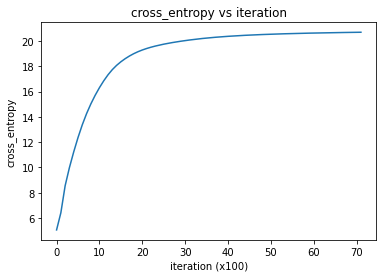

In [259]:
X = glass_X
Y = glass_y
label = glass_label
k_fold_idx, tuning_idx = stratefied_cross_validation(label)
train_idx, test_idx = k_fold_idx[0]
train_X, train_y = X[:,train_idx], Y[:,train_idx]
test_X, test_y = X[:,test_idx], Y[:,test_idx]
score, Y_prediction, cross_entropy, model= LogisticRegression(X= train_X, Y= train_y, test_X = test_X, test_y = test_y, learning_rate= 0.05, num_iterations = 50000, tol = 1e-5, plot= True)

0.28205128205128205
0.3157894736842105
0.34210526315789475
0.5
0.42105263157894735
k-fold average: 0.37219973009446694


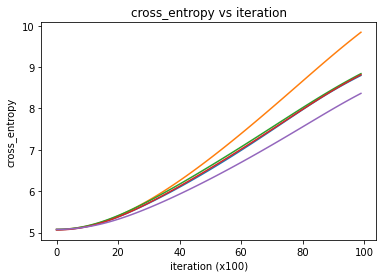

In [260]:
X = glass_X
Y = glass_y
label = glass_label
result = LogisticRegression_CV_test(X, Y, labels=label, learning_rate= 0.001, num_iterations = 10000, tol = 1e-5, k_fold = 5, plot = True)

<ipython-input-168-2f25c95ac884>:6: RuntimeWarning: overflow encountered in exp
  nom = np.exp(p)
<ipython-input-168-2f25c95ac884>:8: RuntimeWarning: invalid value encountered in true_divide
  return nom/denom


0.4666666666666667
0.4666666666666667
0.4666666666666667
0.4666666666666667


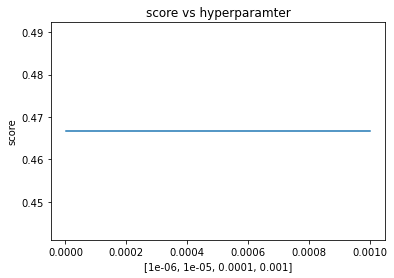

In [239]:
X = iris_X
Y = iris_y
label = iris_label
result = LR_param_tuning(X, Y, label = label, learning_rate= [ 0.1], num_iterations = [5000], tol=[1e-6, 1e-5, 1e-4, 1e-3], plot= True)

0.7407407407407407


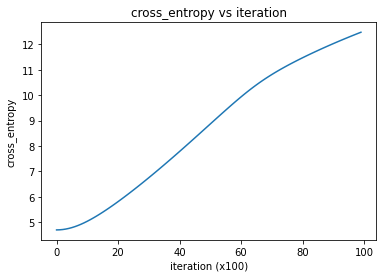

In [261]:
# iris
X = iris_X
Y = iris_y
label = iris_label
k_fold_idx, tuning_idx = stratefied_cross_validation(label)
train_idx, test_idx = k_fold_idx[0]
train_X, train_y = X[:,train_idx], Y[:,train_idx]
test_X, test_y = X[:,test_idx], Y[:,test_idx]
score, Y_prediction, cross_entropy, model= LogisticRegression(X= train_X, Y= train_y, test_X = test_X, test_y = test_y, learning_rate= 0.001, num_iterations = 10000, tol = 1e-5, plot= True)

0.7307692307692307
0.75
0.7777777777777778
0.7037037037037037
0.8148148148148148
k-fold average: 0.7554131054131055


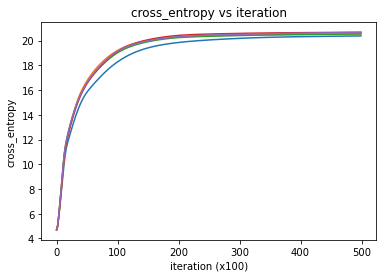

In [262]:
X = iris_X
Y = iris_y
label = iris_label
result = LogisticRegression_CV_test(X, Y, labels=label, learning_rate= 0.005, num_iterations = 50000, tol = 1e-5, k_fold = 5, plot = True)

1.0


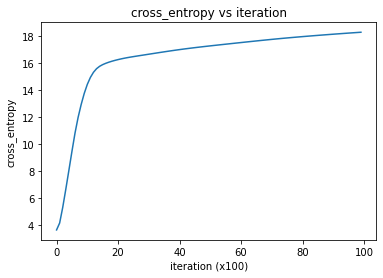

In [263]:
# soybean
X = soybean_X
Y = soybean_y
label = soybean_label
k_fold_idx, tuning_idx = stratefied_cross_validation(label)
train_idx, test_idx = k_fold_idx[0]
train_X, train_y = X[:,train_idx], Y[:,train_idx]
test_X, test_y = X[:,test_idx], Y[:,test_idx]
score, Y_prediction, cross_entropy, model= LogisticRegression(X= train_X, Y= train_y, test_X = test_X, test_y = test_y, learning_rate= 0.005, num_iterations = 10000, tol = 1e-5, plot= True)

1.0
1.0
1.0
1.0
1.0
k-fold average: 1.0


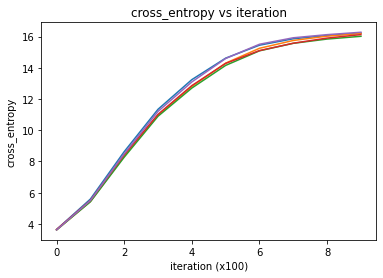

In [264]:
X = soybean_X
Y = soybean_y
label = soybean_label
result = LogisticRegression_CV_test(X, Y, labels=label, learning_rate= 0.01, num_iterations = 1000, tol = 1e-4, k_fold = 5, plot = True)

0.9603174603174603


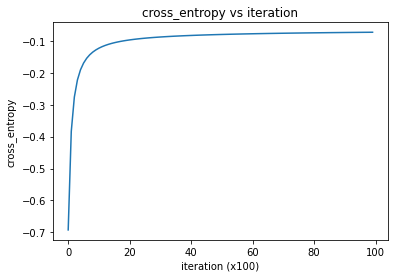

In [268]:
# BC
X = bc_X
Y = bc_y
k_fold_idx, tuning_idx = stratefied_cross_validation(Y)
train_idx, test_idx = k_fold_idx[0]
train_X, train_y = X[:,train_idx], expand_dims(Y[train_idx], axis=0)
test_X, test_y = X[:,test_idx], expand_dims(Y[test_idx], axis = 0)
score, Y_prediction, cross_entropy, model= LogisticRegression(X= train_X, Y= train_y, test_X = test_X, test_y = test_y, learning_rate= 0.005, num_iterations = 10000, tol = 1e-6, plot= True)

0.9855072463768116
0.9855072463768116
0.9855072463768116
0.9855072463768116
0.9855072463768116
0.9855072463768116


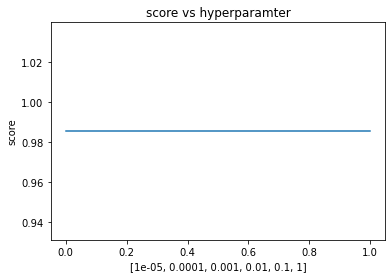

In [269]:
X = bc_X
Y = bc_y
result = LR_param_tuning(X, Y, Y, learning_rate= [0.00001,0.0001, 0.001,0.01, 0.1, 1], num_iterations = [50000], tol=[1e-4], plot= True)

0.9682539682539683
0.9682539682539683
0.9603174603174603
0.9682539682539683
0.9841269841269841
k-fold average: 0.9698412698412697


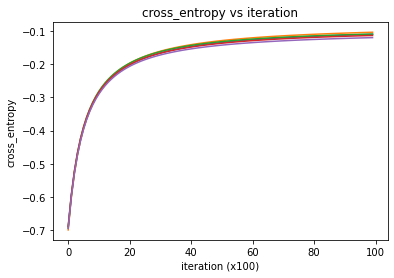

In [270]:
X = bc_X
Y = bc_y
result= LogisticRegression_CV_test(X, Y, Y, learning_rate= 0.001, num_iterations = 10000, tol = 1e-5, k_fold = 5, plot= True)

0.9230769230769231
0.948051948051948
0.9873417721518988
0.9620253164556962
0.9620253164556962
k-fold average: 0.9565042552384325


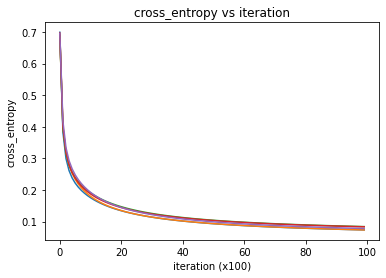

In [154]:
X = vote_X
Y = vote_y
result= LogisticRegression_CV_test(X, Y, Y, learning_rate= 0.005, num_iterations = 10000, tol = 1e-5, k_fold = 5, plot= True)

0.9615384615384616


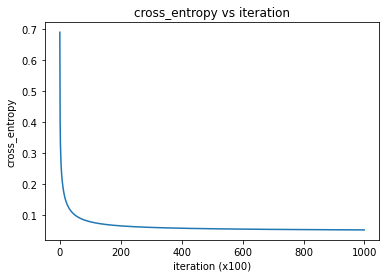

In [155]:
X = vote_X
Y = vote_y
k_fold_idx, tuning_set = stratefied_cross_validation(Y)
train_idx, test_idx = k_fold_idx[0]
train_X, train_y = X[:,train_idx], expand_dims(Y[train_idx], axis=0)
test_X, test_y = X[:,test_idx], expand_dims(Y[test_idx], axis = 0)
score, Y_prediction, cross_entropy, model= LogisticRegression(X= train_X, Y= train_y, test_X = test_X, test_y = test_y, learning_rate= 0.005, num_iterations = 100000, tol = 1e-5, plot= True)